CBOW ( Continuous Bag of Words )
Applying this embedding method on the given hindi reviews dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
import string
import re
import pickle

from __future__ import print_function
from matplotlib import pylab
from matplotlib.font_manager import FontProperties
from sklearn.manifold import TSNE

%matplotlib inline

Giving the location of my dataset folder.

In [ ]:
root = '/content/drive/MyDrive/Project 6th Sem'

Importing the Hindi font as it isn't comes inbuilt on python library.

In [ ]:
hindiFont = FontProperties(fname=os.path.join(root, 'HindiFont.ttf'))

Cleaning dataset

In [ ]:
# Making a function for cleaning the dataset
# This will take data to be cleaned as input along with the language on which I will clean
def clean_text(sentence, language):

    if language == None:
        print(" Language doesn't found : ")
        return None

    exclude = set(string.punctuation)
    remove_digits = str.maketrans('', '', string.digits)

    if language == 'english':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence

    elif language == 'hindi':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)

        sent_temp = ''
        for c in sentence:
            if c == ' ':
                sent_temp += c
            elif ord(u'\u0900') <= ord(c) <= ord(u'\u097F'):
                sent_temp += c
        sentence = sent_temp

        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence

    elif language == 'ma':
        sentence = sentence.lower()
        sentence = ''.join(ch for ch in sentence if ch not in exclude)
        sentence = re.sub('[a-z]', '', sentence)
        sentence = re.sub('[०१२३४५६७८९।]', '', sentence)
        sentence = sentence.translate(remove_digits)
        sentence = sentence.strip()
        sentence = re.sub(" +", " ", sentence)
        return sentence

    else:
        print("Language not found")
        return None

Reading the data from given dataset

In [ ]:
# Making a function to directly call

def read_data(filename, number_of_lines):
    data = list()

    with open(os.path.join(root, filename)) as f:
        for i in  range(number_of_lines):
            data.extend(clean_text(tf.compat.as_str(f.readline()).strip(), 'hindi').split(' '))
    return data

In [ ]:
# Reading data and storing it in variable 'sabd' ( as the hindi of word is sabd )
# As the dataset is large : it will take some time to process
sabd = read_data('Hindi_movies_review_train.csv', 5000000)
print("Data size is %d" % len(sabd))

Data size 5473242


Assuming a vocabulary size

In [ ]:
vocabulary_size = int(len(set(sabd)) // 1.5)

Building the dataset

In [ ]:
# UNK = Unknow

In [ ]:
# Creating helper function to build dataset
# This will take input of readen data and return the dictionary etc useful items
def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size-1))
    dictionary = dict()

    for word, _ in count:
        dictionary[word] = len(dictionary)

    data = list()
    unk_count = 0

    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)

    count[0][1] = unk_count

    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reverse_dictionary

In [ ]:
# Building the dataset and storing the returned result
data, count, dictionary, reverse_dictionary = build_dataset(sabd)
print("Vocabulary size : ", vocabulary_size)
print("Most common words (inclusing UNK) : ", count[:5])
print("Sample data : ", data[:10])
del sabd

Vocabulary size :  13457
Most common words (inclusing UNK) :  [['UNK', 6730], ('', 4989945), ('है', 26342), ('के', 15198), ('में', 12963)]
Sample data :  [1, 2368, 186, 7848, 6, 582, 1245, 212, 179, 5]


Generating Batch ( This is what makes CBOW different from Skip gram )

In [ ]:
data_index = 0

def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1
    batch = np.ndarray(shape=(batch_size, span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)

    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size):
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

In [ ]:
print('Data : ', [reverse_dictionary[di] for di in data[:6]])

Data :  ['', 'चंद्रमोहन', 'शर्मा', 'कोप्रड्यूसर', 'और', 'लीड']


In [ ]:
# Generating different batches

# Taking the batch size = 4
batchSize = 4
for bag_window in [1, 2, 3]:
    data_index = 0
    batch, labels = generate_batch( batchSize, bag_window=bag_window)
    print("\nwith bag_window = %d:" % (bag_window))
    print(" batch:", [[reverse_dictionary[w] for w in bi] for bi in batch])
    print(" label:", [reverse_dictionary[li] for li in labels.reshape(batchSize)])


with bag_window = 1:
 batch: [['', 'शर्मा'], ['चंद्रमोहन', 'कोप्रड्यूसर'], ['शर्मा', 'और'], ['कोप्रड्यूसर', 'लीड']]
 label: ['चंद्रमोहन', 'शर्मा', 'कोप्रड्यूसर', 'और']

with bag_window = 2:
 batch: [['', 'चंद्रमोहन', 'कोप्रड्यूसर', 'और'], ['चंद्रमोहन', 'शर्मा', 'और', 'लीड'], ['शर्मा', 'कोप्रड्यूसर', 'लीड', 'ऐक्टर'], ['कोप्रड्यूसर', 'और', 'ऐक्टर', 'अक्षय']]
 label: ['शर्मा', 'कोप्रड्यूसर', 'और', 'लीड']

with bag_window = 3:
 batch: [['', 'चंद्रमोहन', 'शर्मा', 'और', 'लीड', 'ऐक्टर'], ['चंद्रमोहन', 'शर्मा', 'कोप्रड्यूसर', 'लीड', 'ऐक्टर', 'अक्षय'], ['शर्मा', 'कोप्रड्यूसर', 'और', 'ऐक्टर', 'अक्षय', 'कुमार'], ['कोप्रड्यूसर', 'और', 'लीड', 'अक्षय', 'कुमार', 'की']]
 label: ['कोप्रड्यूसर', 'और', 'लीड', 'ऐक्टर']


Tensorflow Graph

In [ ]:
# To resolve the version issue
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
batch_size = 128
embedding_size = 128
bag_window = 2
valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases,
                                                     inputs=tf.reduce_sum(embeds, 1), labels=train_labels,
                                                     num_sampled=num_sampled, num_classes=vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Tooking nearest words \
This will take some time to process as datatset is large

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    average_loss = 0

    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(batch_size, bag_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l

        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            print("Average loss at step %d: %f" % (step, average_loss))
            average_loss = 0

        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = "Nearest to %s:" % valid_word

                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = "%s %s" % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


Initialized
Average loss at step 0: 7.107762
Nearest to कई: पड़ती वू भादुड़ी बेहोश स्कोर समानताएं विलन रेंसिल
Nearest to पूरी: सुधारते गोलमाल बजते टूपीस सॉफ्ट वीं रिलायंस संपदा
Nearest to ही: बैलेंस चलिए हवेली पप्पी पंप घायल भोजन अविवाहित
Nearest to किरदार: जिंदा चिपका इलेक्ट्रिक घुमाने मैकक्वेरी शराब लड़कर ग्रैंडसन
Nearest to खान: पुरु समन प्रोमो वंडर दीवाना मुंह अंदाज़ा सिंपल
Nearest to बाद: गुंडा भागमभाग होमवर्क पैड्रो सरफिरा अपील छोड़कर कोंकणा
Nearest to बहुत: सत्तर बाधक भविष्यवाणी डेस्टिनेशन शील्ड्स बैली गोलियाँ छूआ
Nearest to उनकी: कुलकर्णी मुक्काबाज वाधवा सास कैस दौड़कर पेशे पियाली
Nearest to में: खलते सुझाव कंसेप्ट इम्पॉसिबल संदीप डॉग पढ़ाते उसी
Nearest to जो: टारजन सपनों चरित्रों नायर टुकड़ोंटुकड़ों जासूसी उन्हें वाडिया
Nearest to की: उपस्थिति साइकोपैथ फ्यार अंताक्षरी दौड़ाना पुजारी अशुद्ध झुंझलाहट
Nearest to दर्शकों: पौराणिक घेर विनोद औलाद राजीव तमाचा टपकने देखने
Nearest to वाले: पोता गुलाब एविल ईमानदारी गोगी सुधीर लक्की द्वारा
Nearest to लिए: जहां पेयर पॉजिटिव छाई हैंड बड़ी प

Output Visualisation

In [ ]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=3, init='pca', n_iter=5000, method='exact') # I have taken n_components = 3 but it's giving same resukt as of 2 dimension
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [ ]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))
    for i, label in enumerate(labels):
        x, y, z = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', fontproperties=hindiFont)
    pylab.show()

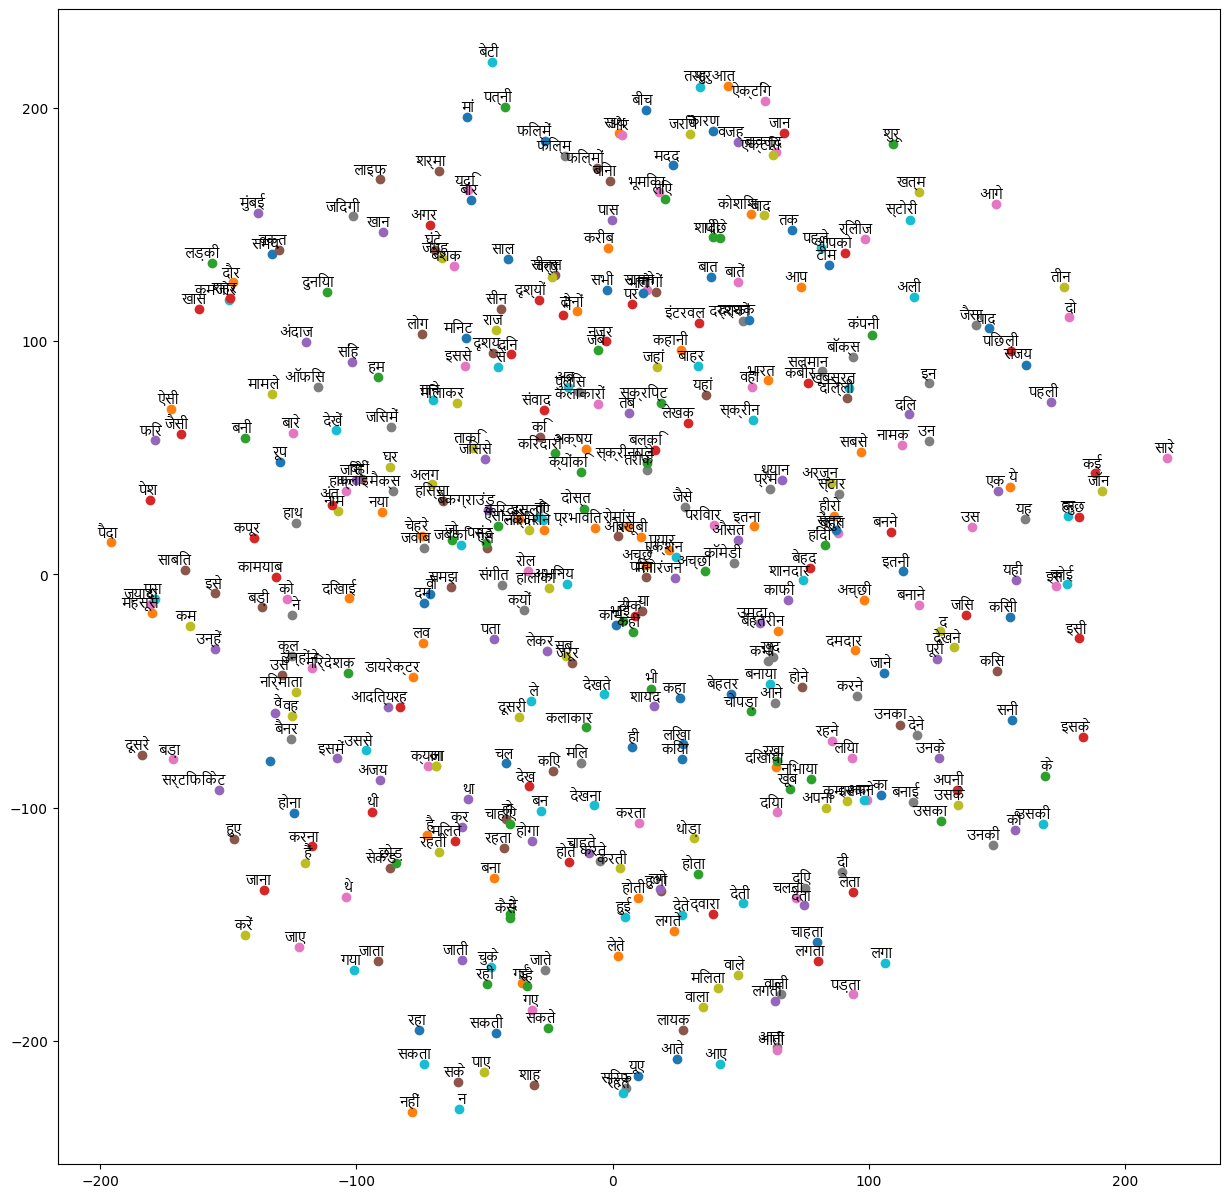

In [ ]:
sabd = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, sabd)

In [ ]:
# To save the work
"""
final_data = {
    'embeddings': final_embeddings,
    'dictionary': dictionary,
    'reverse_dictionary': reverse_dictionary
}

with open(os.path.join(root, 'embeddings_cbow.hi'), 'wb') as f:
    pickle.dump(file=f, obj=final_data)
"""

"\nfinal_data = {\n    'embeddings': final_embeddings,\n    'dictionary': dictionary,\n    'reverse_dictionary': reverse_dictionary\n}\n\nwith open(os.path.join(root, 'embeddings_cbow.hi'), 'wb') as f:\n    pickle.dump(file=f, obj=final_data)\n"

In [ ]:
# To view the saved embeddings
"""
import pickle

with open('/content/drive/MyDrive/Project/embeddings_cbow.hi', 'rb') as f:
    summary = pickle.load(f)

print(summary['embeddings'].shape)
print(summary['dictionary'].keys())
print(summary['reverse_dictionary'].keys())
"""

"\nimport pickle\n\nwith open('/content/drive/MyDrive/Project/embeddings_cbow.hi', 'rb') as f:\n    summary = pickle.load(f)\n\nprint(summary['embeddings'].shape)\nprint(summary['dictionary'].keys())\nprint(summary['reverse_dictionary'].keys())\n"